# **Installation**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

from textwrap import wrap
from matplotlib.cm import get_cmap

from bokeh.palettes import viridis
viridis_palette = viridis(256)

# **Data Import**

In [2]:
# Create a DataFrame from CSV data
df = pd.read_csv("strokes.csv")

# **Selecting Cols**

In [3]:
selected_columns = ['player_id', 'last_name', 'round','hole','hole_score','par_value','yardage',
 'shot', 'shot_type', 'num_of_strokes',
       'from_location_scorer', 'from_location_laser', 'to_location_scorer',
       'to_location_laser', 'distance', 'distance_to_pin', 'in_the_hole',
       'around_the_green', 'first_putt', 'dist_to_hole_after_shot', 'time',
       'lie', 'elevation', 'slope', 'x', 'y', 'z', 'dist_from_center',
       'dist_from_edge']  # Add the column names you want to select
df = df[selected_columns].copy()

# **Inches to Yards**

In [4]:
df['distance_to_pin'] = df['distance_to_pin']/36

df['dist_to_hole_after_shot'] = df['dist_to_hole_after_shot']/36

# **Correcting Lie Locations**

TODO: 

- Impute values I cannot correct
- Check 'Hole' Lies have a 'strokes_to_hole_out' value above 0

In [5]:
df['lie_location'] =    np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        np.where(df['to_location_laser'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Bunker', case=False), 'Bunker',
                        np.where(df['to_location_scorer'].str.contains('Green', case=False), 'Green',
                        np.where(df['to_location_laser'].str.contains('Fairway', case=False), 'Fairway',
                        np.where(df['to_location_scorer'].str.contains('Tree', case=False), 'Rough',
                        #np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        #distance_to_hole_after_the_shot == 0 ~ 'Hole',
                        np.where(df['to_location_scorer'].str.contains('Water', case=False), 'Water', 'Unknown'))))))))

# df = df[df['lie_location'] != 'Unknown']
df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

df['strokes_to_hole_out'] = df['hole_score'] - df['shot'] + df['num_of_strokes'] # df['num_of_strokes'] was 1

result_df = df # del aftee num_of_strokes test

# Shift all values in the 'column_name' down by one row
result_df['next_lie_location'] =  result_df['lie_location']

result_df['lie_location'] = result_df['lie_location'].shift(1)

result_df['lie_location'] =    np.where(result_df['shot'] == 1, 'Tee',result_df['lie_location'])

# **Drop Holes with Incorrect Strokes to Hole Out**

In [6]:
result_df['bad_strokes_to_hole_out_value_flag'] = (result_df['strokes_to_hole_out'] <= 0)

#looks like .iloc 1939 and 5731 are the only messed up holes so thats a W!
selected_rows = result_df[result_df['bad_strokes_to_hole_out_value_flag']]

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

(result_df['strokes_to_hole_out'] == 0).sum()

0

# **Distance to Pin vs Strokes to Hole Out**

### Plot Ideas:

- [Whisker](https://docs.bokeh.org/en/latest/docs/examples/basic/annotations/whisker.html)

- [Ridgeplot](https://docs.bokeh.org/en/latest/docs/examples/topics/categorical/ridgeplot.html)


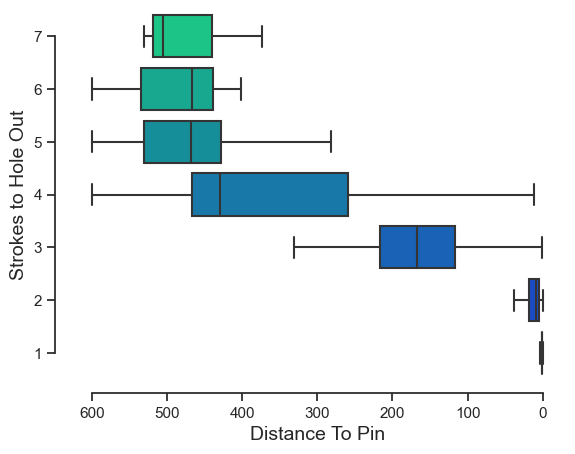

In [7]:
# Set Seaborn style
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a horizontal nested boxplot to show bills by day and time
ax = sns.boxplot(y="strokes_to_hole_out", x="distance_to_pin",
            #hue="lie_location", 
            palette='winter',
            data=result_df,
            orient="h",
            showfliers=False)
sns.despine(offset=10, trim=True)
ax.invert_yaxis()
ax.invert_xaxis()

# Set labels
plt.xlabel('Distance To Pin', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Show the plot
plt.show()

# **Lie Location vs Strokes to Hole Out**

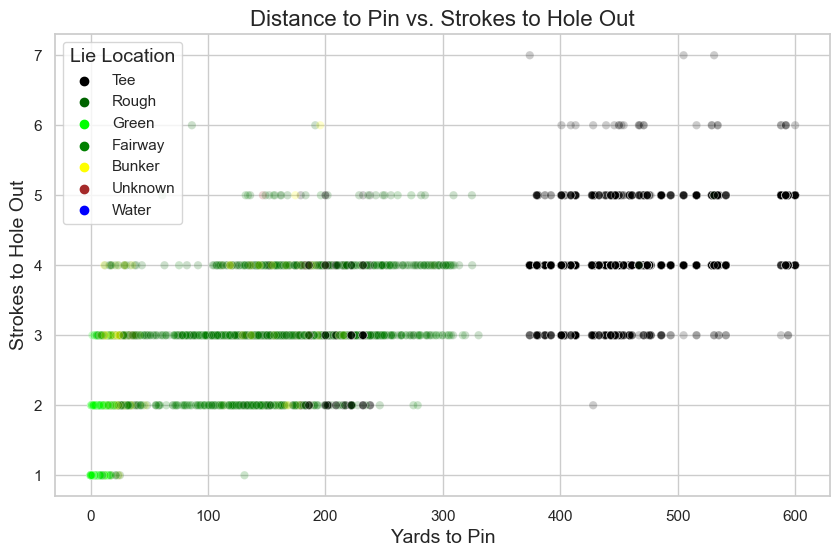

In [8]:
# Define a color palette
pal = {
    'Rough': '#006400',
    'Green': '#00FF00',
    'Fairway': '#008000',
    'Bunker': 'yellow',
    'Tee': 'black',
    'Water': 'blue',
    'Unknown':'brown'
}

# Set Seaborn style
sns.set(style='whitegrid')

# Create scatter plot with improved aesthetics
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='distance_to_pin', y='strokes_to_hole_out',alpha=0.2, hue='lie_location', palette=pal, data=result_df)

# Set plot title and labels
plt.title('Distance to Pin vs. Strokes to Hole Out', fontsize=16)
plt.xlabel('Yards to Pin', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Customize legend
scatter_plot.legend(title='Lie Location', title_fontsize='14', loc='upper left')

# Show the plot
plt.show()

# **Outliers**

### **[Z-Scores](https://medium.com/illumination/how-to-conduct-an-effective-exploratory-data-analysis-eda-fa4e65ab7735)**

In [9]:
z_scores = stats.zscore(result_df['strokes_to_hole_out'])
outliers = result_df[(z_scores < -3) | (z_scores > 3)]
outliers

,player_id,last_name,round,hole,hole_score,par_value,yardage,shot,shot_type,num_of_strokes,...,x,y,z,dist_from_center,dist_from_edge,lie_location,round_hole_combination,strokes_to_hole_out,next_lie_location,bad_strokes_to_hole_out_value_flag
286,20645,Senden,1,3,7,4,387,1,S,1,...,"8,406.74","9,986.92",509.702,920,521,Tee,3,7,Rough,False
5619,27095,Watney,3,5,7,4,520,1,S,1,...,"9,190.43","8,528.56",492.312,909,670,Tee,41,7,Rough,False
8017,30925,Johnson,4,15,7,5,525,1,S,1,...,"11,618.58","8,902.41",504.915,608,468,Tee,69,7,Bunker,False


### **Interquartile Range**

In [10]:
Q1 = result_df['strokes_to_hole_out'].quantile(0.25)
Q3 = result_df['strokes_to_hole_out'].quantile(0.75)
IQR = Q3 - Q1
outliers = result_df[(result_df['strokes_to_hole_out'] < (Q1 - 1.5 * IQR)) | (result_df['strokes_to_hole_out'] > (Q3 + 1.5 * IQR))]
outliers

,player_id,last_name,round,hole,hole_score,par_value,yardage,shot,shot_type,num_of_strokes,...,x,y,z,dist_from_center,dist_from_edge,lie_location,round_hole_combination,strokes_to_hole_out,next_lie_location,bad_strokes_to_hole_out_value_flag
286,20645,Senden,1,3,7,4,387,1,S,1,...,"8,406.74","9,986.92",509.702,920,521,Tee,3,7,Rough,False
5619,27095,Watney,3,5,7,4,520,1,S,1,...,"9,190.43","8,528.56",492.312,909,670,Tee,41,7,Rough,False
8017,30925,Johnson,4,15,7,5,525,1,S,1,...,"11,618.58","8,902.41",504.915,608,468,Tee,69,7,Bunker,False


# **Putting Features**

In [11]:
# distance to pin - distance to edge
result_df['pin_minus_edge'] = result_df['distance_to_pin'] - result_df['dist_from_edge']

In [12]:
# (distance to pin - distance to edge) / (distance to pin)
result_df['pin_minus_edge_over_total'] = (result_df['distance_to_pin'] - result_df['dist_from_edge']) /(result_df['distance_to_pin']) 

In [13]:
# - distance to pin / distance to edge
result_df['pin_over_edge'] = (result_df['distance_to_pin']) /(result_df['dist_from_edge']) 

# **Looks like the 'pin_minus_edge' feature I created is worth keeping**

- Becuse it has a 0.3 corr() to 'strokes_to_hole_out'

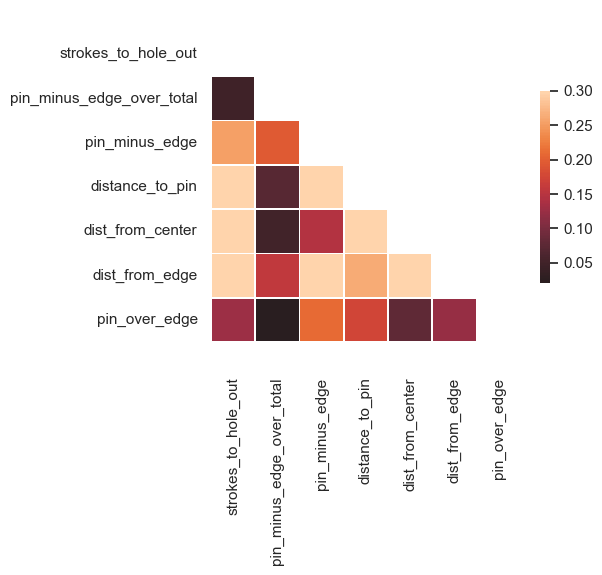

In [14]:
possible_features = result_df

possible_features = possible_features[['strokes_to_hole_out',
'pin_minus_edge_over_total', 
'pin_minus_edge',
'distance_to_pin',
'dist_from_center',
'dist_from_edge','pin_over_edge']]

corr = possible_features.corr()

matrix = np.triu(corr)


plt.figure(figsize=(5, 5))

sns.heatmap(possible_features.corr().abs(), 
            annot=False, 
            mask=matrix,
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()

# **Successfully verifying that 'elevation' and 'slope' do not strongly correlate**

- If the corr() was above 0.5 I'd consider dropping one of the 2

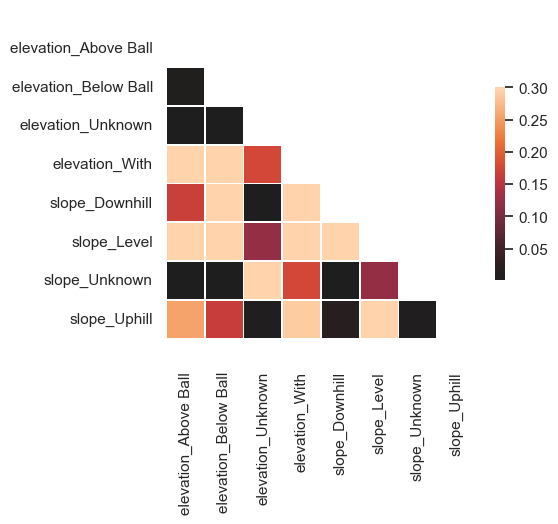

In [15]:
# - compare "Downhill Slope" and "Elevation below ball" for .corr() score
possible_features = result_df

possible_features = possible_features[[ 'elevation', 'slope']]
# Select categorical columns
cat_cols = ['elevation', 'slope']

# One-hot encode categorical columns
possible_features = pd.get_dummies(possible_features, columns=cat_cols)


corr = possible_features.corr()

matrix = np.triu(corr)


plt.figure(figsize=(5, 5))

sns.heatmap(possible_features.corr().abs(), 
            annot=False, 
            mask=matrix,
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()

# **Binning**

for eventual stratification, will drop these binning cols before training, testing, and predicting, it is just to get a good strat

TODO:

- Bin 'dis to edge' for putting model strat
- Bin 'dis to center' for non putting model strat

## **Non Putting Distance Binning**

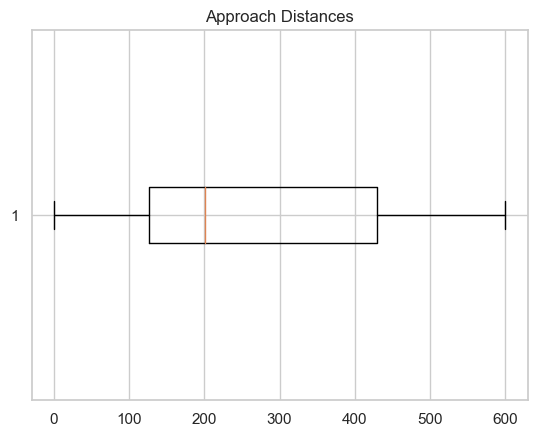

In [16]:
non_green_df = result_df[result_df['lie_location'] != 'Green']
plt.title('Approach Distances')
B = plt.boxplot(non_green_df['distance_to_pin'], vert=False)
plt.show()

In [17]:
whisker_values = [whiskers.get_xdata() for whiskers in B['whiskers']]
median_values = [medians.get_xdata() for medians in B['medians']]

In [18]:
bin1 = (median_values[0][0] + whisker_values[0][0])/2

In [19]:
bin2 = (median_values[0][0] + whisker_values[1][0])/2

# get a dynamic min and max

In [20]:
bins =    [0,       bin1,      bin2,601]
labels = [f'0-{bin1}', f'{bin1}-{bin2}', f'{bin2}-601']

result_df['distance_bins'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False)
print(result_df['distance_bins'].isna().sum())
result_df['distance_bins'] = result_df['distance_bins'].cat.add_categories([''])
result_df['distance_bins'].fillna('', inplace=True)
print(result_df['distance_bins'].isna().sum())

0
0


In [21]:
labels

['0-163.87847222222223', '163.87847222222223-315.0', '315.0-601']

# **Putting Distance Binning**

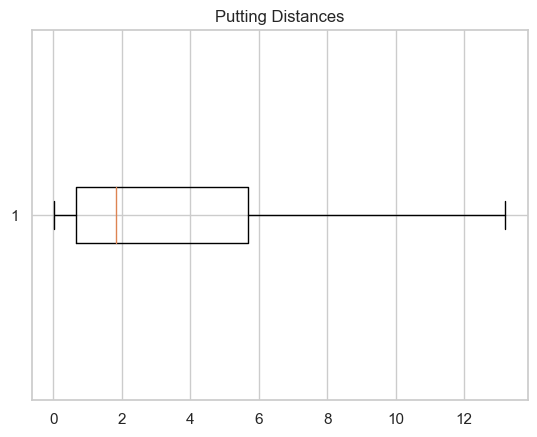

In [22]:
green_df = result_df[result_df['lie_location'] == 'Green']
plt.title('Putting Distances')
B = plt.boxplot(green_df['distance_to_pin'], vert=False,showfliers=False)
plt.show()

In [23]:
whisker_values = [whiskers.get_xdata() for whiskers in B['whiskers']]
median_values = [medians.get_xdata() for medians in B['medians']]

In [24]:
whisker_values[0][0]

0.6666666666666666

In [25]:
median_values[0][0]

1.8333333333333333

In [26]:
whisker_values[1][0]

5.694444444444445

In [27]:
bin1 = (median_values[0][0] + whisker_values[0][0])/2
bin2 = (median_values[0][0] + whisker_values[1][0])/2

In [28]:
bins =    [0,       bin1,      bin2,601]
labels = [f'0-{bin1}', f'{bin1}-{bin2}', f'{bin2}-601']

result_df['distance_bins_putting'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False)
print(result_df['distance_bins_putting'].isna().sum())
result_df['distance_bins_putting'] = result_df['distance_bins_putting'].cat.add_categories([''])
result_df['distance_bins_putting'].fillna('', inplace=True)
print(result_df['distance_bins_putting'].isna().sum())

0
0


# **Saving Feature Engineered Data**

In [29]:
result_df.to_csv('FE_golf.csv')